In [1]:
import numpy as np
import pandas as pd
import time
import os
import pickle
import psutil
from pympler import asizeof

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report

from sklearn.feature_selection import SelectKBest, chi2

from sklearn.feature_selection import SelectFromModel

from imblearn.over_sampling import SMOTE


In [2]:
data_path = "clean_dataset_malware2.csv"  
df = pd.read_csv(data_path)

print("Data shape:", df.shape)
print(df.head())

# Remove duplicates and fill missing values
df.drop_duplicates(inplace=True)
df.fillna(0, inplace=True)

# Mapping the "Class" column: values < 5 become 1 (malicious), value 5 becomes 0 (benign)
df['Class'] = df['Class'].apply(lambda x: 1 if x < 5 else 0)
print("\nClass Distribution:")
print(df['Class'].value_counts())

Data shape: (11526, 392)
   ACCESS_PERSONAL_INFO___  ALTER_PHONE_STATE___  ANTI_DEBUG_____  \
0                        1                     0                0   
1                        3                     0                0   
2                        2                     0                0   
3                        1                     0                0   
4                        3                     0                0   

   CREATE_FOLDER_____  CREATE_PROCESS`_____  CREATE_THREAD_____  \
0                   3                     0                  14   
1                   6                     0                  42   
2                   4                     0                  23   
3                   4                     0                  27   
4                  11                     0                  18   

   DEVICE_ACCESS_____  EXECUTE_____  FS_ACCESS____  FS_ACCESS()____  ...  \
0                   2             0              3                0  ...   
1    

In [3]:
# Split into Features (X) and Target (y)

X = df.drop(columns=['Class'])
y = df['Class']

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (11526, 391)
y shape: (11526,)


In [4]:
# Train-Test Split & Scaling

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print("Train shape:", X_train.shape, "Test shape:", X_test.shape)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

Train shape: (9220, 391) Test shape: (2306, 391)


In [5]:
# Apply SMOTE on Training Data

smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)
print("\nAfter SMOTE, training class distribution:")
print(pd.Series(y_train_smote).value_counts())


After SMOTE, training class distribution:
Class
1    7787
0    7787
Name: count, dtype: int64


In [6]:
# Feature Selection Approach A: Chi-Square Test 

print("\n--- Feature Selection: Chi-Square Test ---")

# Use MinMaxScaler for the chi-square branch.
minmax_scaler = MinMaxScaler()
X_train_minmax = minmax_scaler.fit_transform(X_train_smote)
X_test_minmax = minmax_scaler.transform(X_test_scaled)

k_features = 80  # number of features to select
chi2_selector = SelectKBest(score_func=chi2, k=k_features)
X_train_chi2 = chi2_selector.fit_transform(X_train_minmax, y_train_smote)
X_test_chi2 = chi2_selector.transform(X_test_minmax)
print("Chi-Square selected features shape - Train:", X_train_chi2.shape, "Test:", X_test_chi2.shape)


--- Feature Selection: Chi-Square Test ---
Chi-Square selected features shape - Train: (15574, 80) Test: (2306, 80)


In [7]:
# Feature Selection Approach B: Tree-Based Feature Importance 

print("\n--- Feature Selection: Tree-Based Importance ---")
tree_estimator = RandomForestClassifier(n_estimators=50, random_state=42)
tree_estimator.fit(X_train_smote, y_train_smote)

# Using the median importance as threshold
sfm = SelectFromModel(tree_estimator, threshold="median", prefit=True)
X_train_tree = sfm.transform(X_train_smote)
X_test_tree = sfm.transform(X_test_scaled)
print("Tree-based selected features shape - Train:", X_train_tree.shape, "Test:", X_test_tree.shape)


--- Feature Selection: Tree-Based Importance ---
Tree-based selected features shape - Train: (15574, 196) Test: (2306, 196)


In [8]:
# Final Model Training with GridSearchCV for Each Feature Selection Approach

def train_and_evaluate(X_train_fs, X_test_fs, y_train_fs, y_test, method_label):
    print("\n--- Training Final Model with {} Feature Selection ---".format(method_label))
    rf_model = RandomForestClassifier(random_state=42)
    param_grid = {
        'n_estimators': [50, 100, 150],
        'max_depth': [None, 10, 20]
    }
    grid = GridSearchCV(rf_model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
    start_time = time.time()
    grid.fit(X_train_fs, y_train_fs)
    train_time = time.time() - start_time

    y_pred = grid.predict(X_test_fs)
    y_pred_proba = grid.predict_proba(X_test_fs)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_proba)
    print("{} Features - Best Parameters: {}".format(method_label, grid.best_params_))
    print("{} Features - Best CV Accuracy: {:.4f}".format(method_label, grid.best_score_))
    print("{} Features - Test Accuracy: {:.4f}".format(method_label, acc))
    print("{} Features - Test ROC-AUC: {:.4f}".format(method_label, auc))
    print("{} Features - Training Time: {:.4f} seconds".format(method_label, train_time))
    print("\n{} Features - Classification Report:\n{}".format(method_label, classification_report(y_test, y_pred)))
    
    return grid, train_time

# Training and evaluating on Chi-Square selected features
grid_chi2, train_time_chi2 = train_and_evaluate(X_train_chi2, X_test_chi2, y_train_smote, y_test, "Chi-Square")

# Training and evaluating on Tree-based selected features
grid_tree, train_time_tree = train_and_evaluate(X_train_tree, X_test_tree, y_train_smote, y_test, "Tree-Based")



--- Training Final Model with Chi-Square Feature Selection ---
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Chi-Square Features - Best Parameters: {'max_depth': 20, 'n_estimators': 100}
Chi-Square Features - Best CV Accuracy: 0.9848
Chi-Square Features - Test Accuracy: 0.9718
Chi-Square Features - Test ROC-AUC: 0.9941
Chi-Square Features - Training Time: 18.6532 seconds

Chi-Square Features - Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.91      0.91       359
           1       0.98      0.98      0.98      1947

    accuracy                           0.97      2306
   macro avg       0.95      0.95      0.95      2306
weighted avg       0.97      0.97      0.97      2306


--- Training Final Model with Tree-Based Feature Selection ---
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Tree-Based Features - Best Parameters: {'max_depth': 20, 'n_estimators': 100}
Tree-Based Features - Best CV Accura

In [9]:
# Baseline Model (Full Feature Set) for Comparison

print("\n--- Baseline Model (Full Feature Set) Evaluation ---")
rf_full = RandomForestClassifier(n_estimators=100, random_state=42)
start_time = time.time()
rf_full.fit(X_train_smote, y_train_smote)
train_time_full = time.time() - start_time

y_pred_full = rf_full.predict(X_test_scaled)
y_pred_full_proba = rf_full.predict_proba(X_test_scaled)[:, 1]

acc_full = accuracy_score(y_test, y_pred_full)
auc_full = roc_auc_score(y_test, y_pred_full_proba)
print("Baseline Full Features - Accuracy: {:.4f}".format(acc_full))
print("Baseline Full Features - ROC-AUC: {:.4f}".format(auc_full))
print("Baseline Full Features - Training Time: {:.4f} seconds".format(train_time_full))
print("\nBaseline Full Features - Classification Report:\n", classification_report(y_test, y_pred_full))



--- Baseline Model (Full Feature Set) Evaluation ---
Baseline Full Features - Accuracy: 0.9801
Baseline Full Features - ROC-AUC: 0.9959
Baseline Full Features - Training Time: 4.6731 seconds

Baseline Full Features - Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.94      0.94       359
           1       0.99      0.99      0.99      1947

    accuracy                           0.98      2306
   macro avg       0.96      0.96      0.96      2306
weighted avg       0.98      0.98      0.98      2306



In [10]:
# Tree based selected features and rfecv 

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel, RFECV
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report


print("\n--- Step 1: Tree-Based Feature Selection ---")
# Train a RandomForest to get feature importances
tree_estimator = RandomForestClassifier(n_estimators=50, random_state=42)
tree_estimator.fit(X_train_smote, y_train_smote)

# Use SelectFromModel with a threshold (e.g., median importance)
sfm = SelectFromModel(tree_estimator, threshold="median", prefit=True)
X_train_tree = sfm.transform(X_train_smote)
X_test_tree = sfm.transform(X_test_scaled)
print("After tree-based selection, X_train shape:", X_train_tree.shape)


--- Step 1: Tree-Based Feature Selection ---
After tree-based selection, X_train shape: (15574, 196)


In [74]:
# Refinement using RFECV

print("\n--- Step 2: RFECV on Tree-Based Selected Features ---")
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
rf_for_rfecv = RandomForestClassifier(n_estimators=50, random_state=42)
rfecv = RFECV(estimator=rf_for_rfecv, step=1, cv=cv, scoring='accuracy', min_features_to_select=195, n_jobs=-1)
rfecv.fit(X_train_tree, y_train_smote)
print("RFECV selected {} features out of {}.".format(rfecv.n_features_, X_train_tree.shape[1]))

# Reduce training and testing data to the features selected by RFECV
X_train_final = X_train_tree[:, rfecv.support_]
X_test_final = X_test_tree[:, rfecv.support_]
print("Final feature set shape after RFECV - X_train:", X_train_final.shape)


--- Step 2: RFECV on Tree-Based Selected Features ---
RFECV selected 195 features out of 196.
Final feature set shape after RFECV - X_train: (15574, 195)


In [78]:
print("\n--- Step 3: Final Model Training with GridSearchCV ---")
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20]
}
final_rf = RandomForestClassifier(random_state=42)
grid = GridSearchCV(final_rf, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)

start_time = time.time()
grid.fit(X_train_final, y_train_smote)
train_time = time.time() - start_time
print("\nGridSearchCV training time: {:.4f} seconds".format(train_time))
print("Best parameters found:", grid.best_params_)
print("Best CV accuracy: {:.4f}".format(grid.best_score_))


--- Step 3: Final Model Training with GridSearchCV ---
Fitting 5 folds for each of 9 candidates, totalling 45 fits

GridSearchCV training time: 39.7676 seconds
Best parameters found: {'max_depth': None, 'n_estimators': 150}
Best CV accuracy: 0.9891


In [79]:
# Evaluate the Final Model

y_pred = grid.predict(X_test_final)
y_pred_proba = grid.predict_proba(X_test_final)[:, 1]

acc = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_proba)
print("\n=== Final Model Evaluation on Test Data ===")
print("Test Accuracy: {:.4f}".format(acc))
print("Test ROC-AUC: {:.4f}".format(auc))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


=== Final Model Evaluation on Test Data ===
Test Accuracy: 0.9783
Test ROC-AUC: 0.9961

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.92      0.93       359
           1       0.99      0.99      0.99      1947

    accuracy                           0.98      2306
   macro avg       0.96      0.96      0.96      2306
weighted avg       0.98      0.98      0.98      2306



In [82]:
# Saving the Final Model

final_model_tree = grid_tree.best_estimator_
with open('final_model_tree_F.pkl', 'wb') as f:
    pickle.dump(final_model_tree, f)
print("Final Tree-Based model saved to final_model_tree.pkl")

Final Tree-Based model saved to final_model_tree.pkl


In [15]:
import time
import os
import pickle
import psutil
from pympler import asizeof


final_model = grid.best_estimator_  

# Also assume X_test_final is your test data (with selected features) 
# For demonstration, if using full test data, then use X_test_scaled instead

# Measure Inference Time per Sample 
start_time = time.time()
# Obtain predictions on the test set
y_pred_proba = final_model.predict_proba(X_test_final)[:, 1]
end_time = time.time()

total_inference_time = end_time - start_time
num_samples = X_test_final.shape[0]
avg_inference_time = total_inference_time / num_samples

print("Total inference time for {} samples: {:.4f} seconds".format(num_samples, total_inference_time))
print("Average inference time per sample: {:.6f} seconds".format(avg_inference_time))

Total inference time for 2306 samples: 0.0380 seconds
Average inference time per sample: 0.000016 seconds


In [36]:
# Estimate Model Memory Footprint 
# Save the model to disk and check the file size.

model_filename = 'final_model.pkl'
with open(model_filename, 'wb') as f:
    pickle.dump(final_model, f)
model_file_size = os.path.getsize(model_filename) / 1024  # in KB
print("Model file size (via pickle): {:.2f} KB".format(model_file_size))

# Estimate the model's in-memory size using pympler.

model_memory_size = asizeof.asizeof(final_model) / 1024  # in KB
print("Estimated in-memory model size: {:.2f} KB".format(model_memory_size))

# Check CPU Usage During Inference 
# Measuring CPU usage during 100 individual predictions.
process = psutil.Process()
cpu_usage_samples = []

# Warm-up prediction
_ = final_model.predict_proba(X_test_final[:1])





Model file size (via pickle): 10074.30 KB
Estimated in-memory model size: 178.09 KB


In [ ]:
import optuna
from sklearn.model_selection import cross_val_score

def objective(trial):
    # Define hyperparameters to tune
    n_estimators = trial.suggest_int('n_estimators', 50, 200)
    max_depth = trial.suggest_categorical('max_depth', [None, 10, 20, 30])
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 4)
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', None])
    
    # Create classifier with cost-sensitive learning
    clf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, max_features=max_features, random_state=42, class_weight='balanced')
    
    # Use cross-validation to evaluate performance on training data (using 5-fold CV)
    scores = cross_val_score(clf, X_train_final, y_train_smote, cv=5, scoring='accuracy', n_jobs=-1)
    return scores.mean()

print("\n--- Bayesian Optimization with Optuna ---")
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

print("Optuna Best Params:", study.best_params)
print("Optuna Best CV Accuracy: {:.4f}".format(study.best_value))

# Train final model with best parameters from Optuna
best_rf = RandomForestClassifier(**study.best_params, random_state=42, class_weight='balanced')
best_rf.fit(X_train_final, y_train_smote)
y_pred_optuna = best_rf.predict(X_test_final)
y_pred_optuna_proba = best_rf.predict_proba(X_test_final)[:, 1]
acc_optuna = accuracy_score(y_test, y_pred_optuna)
auc_optuna = roc_auc_score(y_test, y_pred_optuna_proba)

print("Optuna Test Accuracy: {:.4f}".format(acc_optuna))
print("Optuna Test ROC-AUC: {:.4f}".format(auc_optuna))
print("\nOptuna Classification Report:\n", classification_report(y_test, y_pred_optuna))


[I 2025-03-24 18:11:23,005] A new study created in memory with name: no-name-652add6d-615a-42a9-8b52-d4699135ff71



--- Bayesian Optimization with Optuna ---


[I 2025-03-24 18:11:31,826] Trial 0 finished with value: 0.9767567584285126 and parameters: {'n_estimators': 164, 'max_depth': 10, 'min_samples_split': 6, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 0 with value: 0.9767567584285126.
[I 2025-03-24 18:11:38,643] Trial 1 finished with value: 0.9865164003294808 and parameters: {'n_estimators': 156, 'max_depth': None, 'min_samples_split': 6, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 1 with value: 0.9865164003294808.
[I 2025-03-24 18:11:43,291] Trial 2 finished with value: 0.9858743251365191 and parameters: {'n_estimators': 95, 'max_depth': None, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 1 with value: 0.9865164003294808.
[I 2025-03-24 18:11:46,922] Trial 3 finished with value: 0.9861953730421614 and parameters: {'n_estimators': 72, 'max_depth': None, 'min_samples_split': 10, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 1 with value: 0.986516400

Optuna Best Params: {'n_estimators': 187, 'max_depth': 30, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 'sqrt'}
Optuna Best CV Accuracy: 0.9897
Optuna Test Accuracy: 0.9796
Optuna Test ROC-AUC: 0.9960

Optuna Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.92      0.93       359
           1       0.99      0.99      0.99      1947

    accuracy                           0.98      2306
   macro avg       0.97      0.95      0.96      2306
weighted avg       0.98      0.98      0.98      2306



In [18]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
import time

# Defining the XGBoost classifier
xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

# Defining a parameter grid for XGBoost
param_grid_xgb = {
    'n_estimators': [150, 200, 250],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Set up GridSearchCV
grid_xgb = GridSearchCV(xgb_model, param_grid=param_grid_xgb, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)

print("\n--- Training XGBoost with GridSearchCV ---")
start_time = time.time()
grid_xgb.fit(X_train_final, y_train_smote)
train_time_xgb = time.time() - start_time

print("XGBoost - Best Parameters:", grid_xgb.best_params_)
print("XGBoost - Best CV Accuracy: {:.4f}".format(grid_xgb.best_score_))
print("XGBoost - Training Time: {:.2f} seconds".format(train_time_xgb))



--- Training XGBoost with GridSearchCV ---
Fitting 5 folds for each of 108 candidates, totalling 540 fits


c:\Users\archi\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:05:12] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost - Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 250, 'subsample': 0.8}
XGBoost - Best CV Accuracy: 0.9845
XGBoost - Training Time: 444.61 seconds


In [19]:
# Predict on test data
y_pred_xgb = grid_xgb.predict(X_test_final)
y_pred_xgb_proba = grid_xgb.predict_proba(X_test_final)[:, 1]

# Calculate accuracy and ROC-AUC
acc_xgb = accuracy_score(y_test, y_pred_xgb)
auc_xgb = roc_auc_score(y_test, y_pred_xgb_proba)

print("\n=== XGBoost Model Evaluation on Test Data ===")
print("Test Accuracy: {:.4f}".format(acc_xgb))
print("Test ROC-AUC: {:.4f}".format(auc_xgb))
print("\nClassification Report:\n", classification_report(y_test, y_pred_xgb))



=== XGBoost Model Evaluation on Test Data ===
Test Accuracy: 0.9822
Test ROC-AUC: 0.9970

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.93      0.94       359
           1       0.99      0.99      0.99      1947

    accuracy                           0.98      2306
   macro avg       0.97      0.96      0.97      2306
weighted avg       0.98      0.98      0.98      2306



In [30]:
# Save the best XGBoost model using pickle
model_filename = 'final_xgb_model_F.pkl'
with open(model_filename, 'wb') as f:
    pickle.dump(grid_xgb.best_estimator_, f)
print("\nFinal XGBoost model saved to", model_filename)



Final XGBoost model saved to final_xgb_model_F.pkl


In [ ]:
import time
import os
import pickle
import psutil
from pympler import asizeof


model_filename = 'final_xgb_model_F.pkl'
with open(model_filename, 'rb') as f:
    final_xgb_model_F = pickle.load(f)
print("Final XGBoost model loaded from", model_filename)


# Measure Inference Time per Sample

start_time = time.time()


# Performing prediction on the entire test set
y_pred_proba = final_xgb_model_F.predict_proba(X_test_final)[:, 1]
end_time = time.time()

total_inference_time = end_time - start_time
num_samples = X_test_final.shape[0]
avg_inference_time = total_inference_time / num_samples

print("Total inference time for {} samples: {:.4f} seconds".format(num_samples, total_inference_time))
print("Average inference time per sample: {:.6f} seconds".format(avg_inference_time))


# Estimating Model Memory Footprint
# Saving the model to disk and measuring the file size.

with open(model_filename, 'wb') as f:
    pickle.dump(final_xgb_model_F, f)
model_file_size = os.path.getsize(model_filename) / 1024  
print("Model file size (via pickle): {:.2f} KB".format(model_file_size))

# Estimating the in-memory size of the model using pympler.

model_memory_size = asizeof.asizeof(final_xgb_model_F) / 1024  # in KB
print("Estimated in-memory model size: {:.2f} KB".format(model_memory_size))



Final XGBoost model loaded from final_xgb_model_F.pkl
Total inference time for 2306 samples: 0.0190 seconds
Average inference time per sample: 0.000008 seconds
Model file size (via pickle): 633.85 KB
Estimated in-memory model size: 5.45 KB


In [37]:
import numpy as np
import time
import os
import pickle
import psutil
from pympler import asizeof
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score, classification_report

# --- Threshold Tuning and Evaluation ---
# Predict probabilities on the test set using the final model
y_pred_proba = final_xgb_model_F.predict_proba(X_test_final)[:, 1]

# Define a range of thresholds to try
thresholds = np.linspace(0.3, 0.7, 21)
best_thresh = 0.5
best_f1 = 0

# Iterate over thresholds to find the one with the best F1 score
for thresh in thresholds:
    y_pred_thresh = (y_pred_proba >= thresh).astype(int)
    f1 = f1_score(y_test, y_pred_thresh)
    if f1 > best_f1:
        best_f1 = f1
        best_thresh = thresh

print("Optimal decision threshold:", best_thresh)
print("F1 Score at optimal threshold: {:.4f}".format(best_f1))

# Evaluate final metrics using the optimal threshold
y_pred_final = (y_pred_proba >= best_thresh).astype(int)
test_accuracy = accuracy_score(y_test, y_pred_final)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print("Test Accuracy at optimal threshold: {:.4f}".format(test_accuracy))
print("Test ROC-AUC: {:.4f}".format(roc_auc))
print("\nFinal Model Evaluation with Threshold Tuning:")
print(classification_report(y_test, y_pred_final))

# --- Save the Final Model ---
model_filename = 'final_xgb_model_F.pkl'
with open(model_filename, 'wb') as f:
    pickle.dump(final_xgb_model_F, f)
print("Model saved to", model_filename)

# --- Measure Inference Time ---
start_time = time.time()
# Run inference on the full test set
_ = final_xgb_model_F.predict_proba(X_test_final)
end_time = time.time()
total_inference_time = end_time - start_time
num_samples = X_test_final.shape[0]
avg_inference_time = total_inference_time / num_samples

print("Total inference time for {} samples: {:.4f} seconds".format(num_samples, total_inference_time))
print("Average inference time per sample: {:.6f} seconds".format(avg_inference_time))

# --- Estimate Model Memory Footprint ---
# Option A: File size via pickle
model_file_size = os.path.getsize(model_filename) / 1024  # in KB
# Option B: In-memory size using pympler
model_memory_size = asizeof.asizeof(final_xgb_model_F) / 1024  # in KB

print("Model file size (via pickle): {:.2f} KB".format(model_file_size))
print("Estimated in-memory model size: {:.2f} KB".format(model_memory_size))




Optimal decision threshold: 0.39999999999999997
F1 Score at optimal threshold: 0.9898
Test Accuracy at optimal threshold: 0.9827
Test ROC-AUC: 0.9970

Final Model Evaluation with Threshold Tuning:
              precision    recall  f1-score   support

           0       0.97      0.92      0.94       359
           1       0.99      0.99      0.99      1947

    accuracy                           0.98      2306
   macro avg       0.98      0.96      0.97      2306
weighted avg       0.98      0.98      0.98      2306

Model saved to final_xgb_model_F.pkl
Total inference time for 2306 samples: 0.0080 seconds
Average inference time per sample: 0.000003 seconds
Model file size (via pickle): 633.85 KB
Estimated in-memory model size: 5.45 KB


In [30]:
print(X_train_final.shape)

(15574, 195)


In [38]:
import time, os, pickle, psutil
from pympler import asizeof
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report

# Train CatBoost
print("\n--- Training CatBoost ---")
cat_model = CatBoostClassifier(random_state=42, verbose=0)
start_time = time.time()
cat_model.fit(X_train_final, y_train_smote)
cat_train_time = time.time() - start_time

# Evaluate on test data
y_pred_cat = cat_model.predict(X_test_final)
y_pred_cat_proba = cat_model.predict_proba(X_test_final)[:, 1]
acc_cat = accuracy_score(y_test, y_pred_cat)
auc_cat = roc_auc_score(y_test, y_pred_cat_proba)
report_cat = classification_report(y_test, y_pred_cat)

print("CatBoost Test Accuracy: {:.4f}".format(acc_cat))
print("CatBoost Test ROC-AUC: {:.4f}".format(auc_cat))
print("CatBoost Training Time: {:.2f} seconds".format(cat_train_time))
print("CatBoost Classification Report:\n", report_cat)

# Measure Inference Time
start_time = time.time()
_ = cat_model.predict_proba(X_test_final)
total_inference_time = time.time() - start_time
avg_inference_time = total_inference_time / X_test_final.shape[0]
print("CatBoost Total inference time for {} samples: {:.4f} seconds".format(X_test_final.shape[0], total_inference_time))
print("CatBoost Average inference time per sample: {:.6f} seconds".format(avg_inference_time))

# Estimate Memory Footprint
model_filename = 'cat_model.pkl'
with open(model_filename, 'wb') as f:
    pickle.dump(cat_model, f)
model_file_size = os.path.getsize(model_filename) / 1024  # in KB
model_memory_size = asizeof.asizeof(cat_model) / 1024  # in KB
print("CatBoost Model file size (via pickle): {:.2f} KB".format(model_file_size))
print("CatBoost Estimated in-memory model size: {:.2f} KB".format(model_memory_size))





--- Training CatBoost ---
CatBoost Test Accuracy: 0.9770
CatBoost Test ROC-AUC: 0.9957
CatBoost Training Time: 23.60 seconds
CatBoost Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.91      0.93       359
           1       0.98      0.99      0.99      1947

    accuracy                           0.98      2306
   macro avg       0.96      0.95      0.96      2306
weighted avg       0.98      0.98      0.98      2306

CatBoost Total inference time for 2306 samples: 0.0050 seconds
CatBoost Average inference time per sample: 0.000002 seconds
CatBoost Model file size (via pickle): 1110.15 KB
CatBoost Estimated in-memory model size: 9.29 KB


In [71]:
import time, os, pickle, psutil
from pympler import asizeof
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report

# Train Logistic Regression with L1 penalty (for sparsity)
print("\n--- Training Logistic Regression (L1 Regularization) ---")
logreg = LogisticRegression(penalty='l1', solver='liblinear', random_state=42)
start_time = time.time()
logreg.fit(X_train_final, y_train_smote)
logreg_train_time = time.time() - start_time

# Evaluate on test data
y_pred_lr = logreg.predict(X_test_final)
y_pred_lr_proba = logreg.predict_proba(X_test_final)[:, 1]
acc_lr = accuracy_score(y_test, y_pred_lr)
auc_lr = roc_auc_score(y_test, y_pred_lr_proba)
report_lr = classification_report(y_test, y_pred_lr)

print("Logistic Regression Test Accuracy: {:.4f}".format(acc_lr))
print("Logistic Regression Test ROC-AUC: {:.4f}".format(auc_lr))
print("Logistic Regression Training Time: {:.2f} seconds".format(logreg_train_time))
print("Logistic Regression Classification Report:\n", report_lr)

# Measure Inference Time
start_time = time.time()
_ = logreg.predict_proba(X_test_final)
total_inference_time = time.time() - start_time
avg_inference_time = total_inference_time / X_test_final.shape[0]
print("Logistic Regression Total inference time for {} samples: {:.4f} seconds".format(X_test_final.shape[0], total_inference_time))
print("Logistic Regression Average inference time per sample: {:.6f} seconds".format(avg_inference_time))

# Estimate Memory Footprint
model_filename = 'logreg_model.pkl'
with open(model_filename, 'wb') as f:
    pickle.dump(logreg, f)
model_file_size = os.path.getsize(model_filename) / 1024  # in KB
model_memory_size = asizeof.asizeof(logreg) / 1024  # in KB
print("Logistic Regression Model file size (via pickle): {:.2f} KB".format(model_file_size))
print("Logistic Regression Estimated in-memory model size: {:.2f} KB".format(model_memory_size))





--- Training Logistic Regression (L1 Regularization) ---
Logistic Regression Test Accuracy: 0.9467
Logistic Regression Test ROC-AUC: 0.9626
Logistic Regression Training Time: 15.91 seconds
Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.87      0.84       359
           1       0.98      0.96      0.97      1947

    accuracy                           0.95      2306
   macro avg       0.89      0.92      0.90      2306
weighted avg       0.95      0.95      0.95      2306

Logistic Regression Total inference time for 2306 samples: 0.0010 seconds
Logistic Regression Average inference time per sample: 0.000000 seconds
Logistic Regression Model file size (via pickle): 1.73 KB
Logistic Regression Estimated in-memory model size: 5.15 KB


c:\Users\archi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [67]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Display plots inline if you're in a Jupyter environment
%matplotlib inline

# Create a unified color palette for the four models
cmap = plt.cm.get_cmap('Set2')

model_list = ['Logistic Regression', 'Random Forest', 'CatBoost', 'XGBoost']
model_colors = {}
for i, model in enumerate(model_list):
    # Evenly space the colors for each model
    model_colors[model] = cmap(i / len(model_list))

# Helper function to map each model in a DataFrame row to the correct color
def get_colors_for_df(df):
    return [model_colors[m] for m in df['Model']]

# Build a summary DataFrame of your final results
comparison_data = {
    'Model': [
        'Logistic Regression',
        'Random Forest',
        'CatBoost',
        'XGBoost'
    ],
    'Accuracy (%)': [
        95.45,   # LR
        97.96,   # RF
        97.70,   # CatBoost
        98.27    # XGBoost
    ],
    'ROC-AUC (%)': [
        95.91,   # LR
        99.60,   # RF
        99.57,   # CatBoost
        99.70    # XGBoost
    ],
    'Training Time (s)': [
        10.15,   # LR
        33.83,    # We'll fill in below or keep None if you prefer not to show
        23.60,   # CatBoost
        444.61     # If you want to share XGBoost train time, fill it in
    ],
    'Total Inference Time (s)': [
        0.0020,  # LR for 2306 samples
        0.0380,  # RF
        0.0050,  # CatBoost
        0.0080   # XGBoost
    ],
    'Avg Inference Time (µs)': [
        1.0,     # 0.000001 s => 1 microsecond
        16.0,    # 0.000016 s => 16 microseconds
        2.0,     # 0.000002 s => 2 microseconds
        3.0      # 0.000003 s => 3 microseconds
    ],
    'Model File Size (KB)': [
        2.23,    # LR
        10074.30,# RF
        1110.15, # CatBoost
        633.85   # XGBoost
    ],
    'Memory Size (KB)': [
        6.15,    # LR
        178.09,  # RF
        9.29,    # CatBoost
        5.45     # XGBoost
    ]
}

comparison_df = pd.DataFrame(comparison_data)
comparison_df


C:\Users\archi\AppData\Local\Temp\ipykernel_34700\2287460944.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('Set2')


,Model,Accuracy (%),ROC-AUC (%),Training Time (s),Total Inference Time (s),Avg Inference Time (µs),Model File Size (KB),Memory Size (KB)
0,Logistic Regression,95.45,95.91,10.15,0.002,1.0,2.23,6.15
1,Random Forest,97.96,99.60,33.83,0.038,16.0,10074.30,178.09
2,CatBoost,97.70,99.57,23.60,0.005,2.0,1110.15,9.29
3,XGBoost,98.27,99.70,444.61,0.008,3.0,633.85,5.45


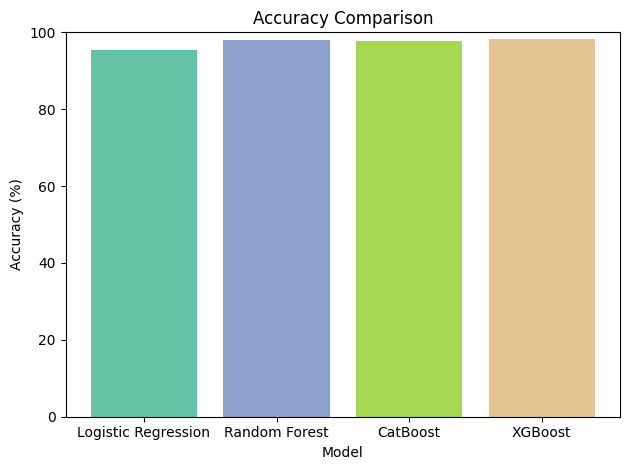

In [41]:
plt.figure()
plt.bar(
    comparison_df['Model'],
    comparison_df['Accuracy (%)'],
    color=get_colors_for_df(comparison_df)
)
plt.title('Accuracy Comparison')
plt.xlabel('Model')
plt.ylabel('Accuracy (%)')
plt.ylim([0, 100])  # Adjust for clarity
plt.tight_layout()
plt.show()


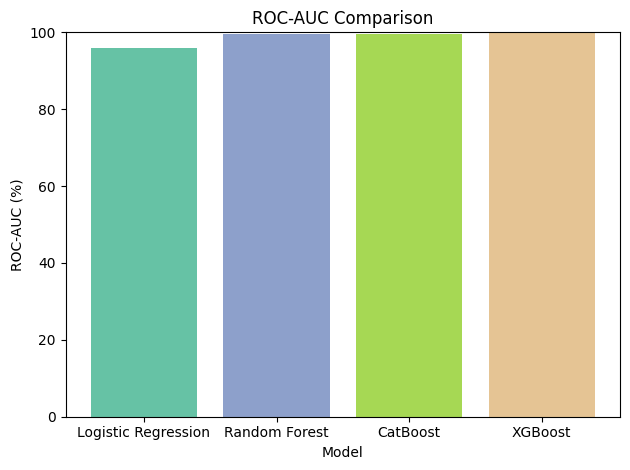

In [42]:
plt.figure()
plt.bar(
    comparison_df['Model'],
    comparison_df['ROC-AUC (%)'],
    color=get_colors_for_df(comparison_df)
)
plt.title('ROC-AUC Comparison')
plt.xlabel('Model')
plt.ylabel('ROC-AUC (%)')
plt.ylim([0, 100])
plt.tight_layout()
plt.show()


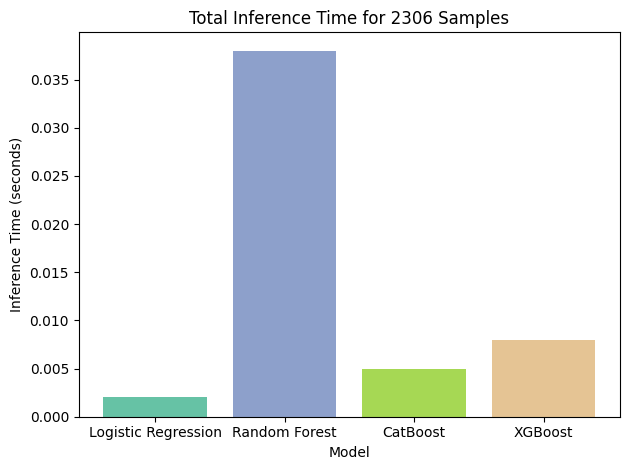

In [44]:
plt.figure()
plt.bar(
    comparison_df['Model'],
    comparison_df['Total Inference Time (s)'],
    color=get_colors_for_df(comparison_df)
)
plt.title('Total Inference Time for 2306 Samples')
plt.xlabel('Model')
plt.ylabel('Inference Time (seconds)')
plt.tight_layout()
plt.show()


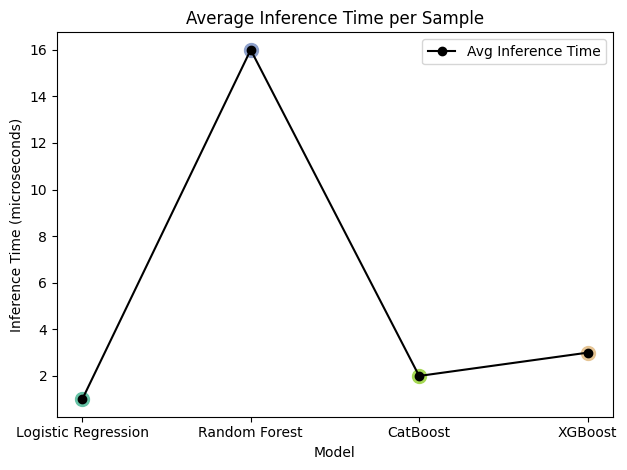

In [45]:
plt.figure()
# We'll connect them with a single color line for clarity:
plt.plot(
    comparison_df['Model'],
    comparison_df['Avg Inference Time (µs)'],
    marker='o',
    linestyle='-',
    color='black',
    label='Avg Inference Time'
)

# Add scatter points in each model's color
for i, row in comparison_df.iterrows():
    plt.scatter(
        row['Model'],
        row['Avg Inference Time (µs)'],
        color=model_colors[row['Model']],
        s=100
    )

plt.title('Average Inference Time per Sample')
plt.xlabel('Model')
plt.ylabel('Inference Time (microseconds)')
plt.legend()
plt.tight_layout()
plt.show()


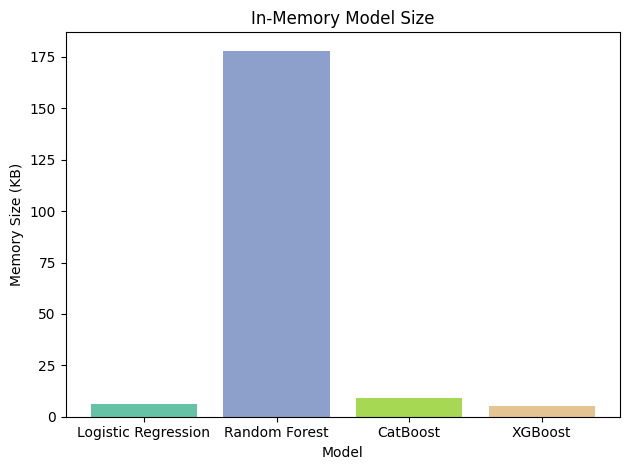

In [47]:
plt.figure()
plt.bar(
    comparison_df['Model'],
    comparison_df['Memory Size (KB)'],
    color=get_colors_for_df(comparison_df)
)
plt.title('In-Memory Model Size')
plt.xlabel('Model')
plt.ylabel('Memory Size (KB)')
plt.tight_layout()
plt.show()


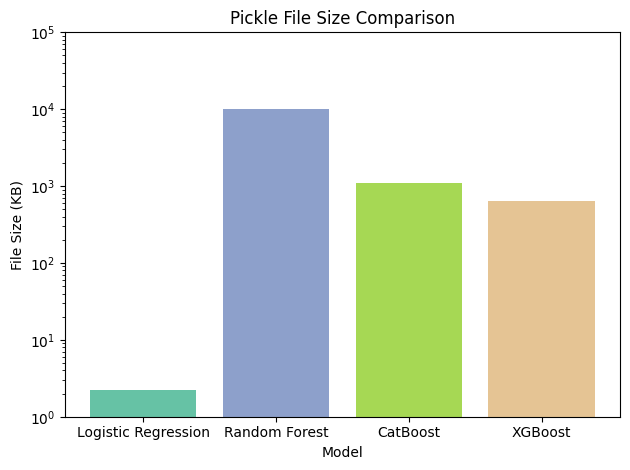

In [48]:
plt.figure()
plt.bar(
    comparison_df['Model'],
    comparison_df['Model File Size (KB)'],
    color=get_colors_for_df(comparison_df)
)
plt.title('Pickle File Size Comparison')
plt.xlabel('Model')
plt.ylabel('File Size (KB)')

# Apply a logarithmic scale to the y-axis
plt.yscale('log')

# Optional: You can manually specify y-ticks to make them more intuitive
# For example, let's place them at powers of 10:
plt.yticks([1, 10, 100, 1000, 10000, 100000])

plt.tight_layout()
plt.show()


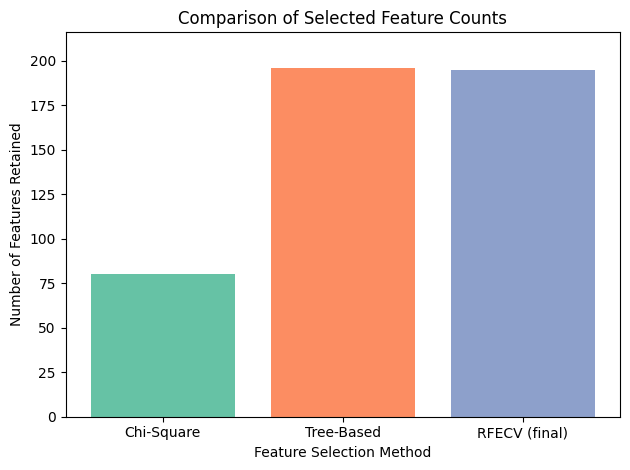

In [49]:
import matplotlib.pyplot as plt

# Make sure to run %matplotlib inline if using a Jupyter notebook
%matplotlib inline

methods = ['Chi-Square', 'Tree-Based', 'RFECV (final)']
num_features = [80, 196, 195]

# Optional: use a color palette
colors = ['#66c2a5', '#fc8d62', '#8da0cb']  # Example from 'Set2'

plt.figure()
plt.bar(methods, num_features, color=colors)
plt.title('Comparison of Selected Feature Counts')
plt.xlabel('Feature Selection Method')
plt.ylabel('Number of Features Retained')
plt.ylim([0, max(num_features)+20])  # Adjust for clarity
plt.tight_layout()
plt.show()


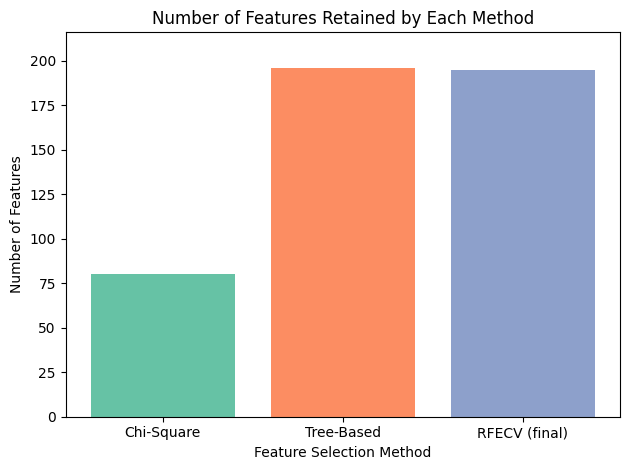

In [52]:
import matplotlib.pyplot as plt

methods = ["Chi-Square", "Tree-Based", "RFECV (final)"]
num_features = [80, 196, 195]

plt.figure()
plt.bar(methods, num_features, color=["#66c2a5", "#fc8d62", "#8da0cb"])
plt.title("Number of Features Retained by Each Method")
plt.xlabel("Feature Selection Method")
plt.ylabel("Number of Features")
plt.ylim([0, max(num_features)+20])  # some padding above the largest bar
plt.tight_layout()
plt.show()


In [53]:
import pandas as pd

fs_data = {
    'Method': ["Chi-Square", "Tree-Based", "Tree-Based + RFECV"],
    'X_train Shape': ["(15574, 80)", "(15574, 196)", "(15574, 195)"],
    'X_test Shape': ["(2306, 80)", "(2306, 196)", "(2306, 195)"]
}

fs_df = pd.DataFrame(fs_data)
fs_df


,Method,X_train Shape,X_test Shape
0,Chi-Square,"(15574, 80)","(2306, 80)"
1,Tree-Based,"(15574, 196)","(2306, 196)"
2,Tree-Based + RFECV,"(15574, 195)","(2306, 195)"


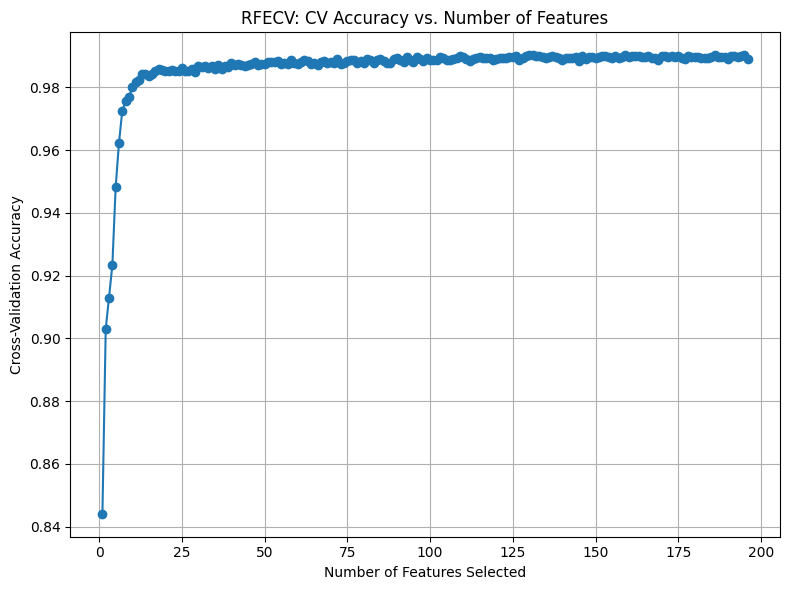

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Extract cross-validation scores from the RFECV object
cv_scores = rfecv.cv_results_['mean_test_score']  
n_features = range(1, len(cv_scores) + 1)         

plt.figure(figsize=(8, 6))

# Plot the scores as a line with circular markers
plt.plot(n_features, cv_scores, marker='o', linestyle='-')



plt.title('RFECV: CV Accuracy vs. Number of Features')
plt.xlabel('Number of Features Selected')
plt.ylabel('Cross-Validation Accuracy')
plt.grid(True)            
plt.tight_layout()
plt.savefig("rfecv_lineplot.png", dpi=300) 
plt.show()


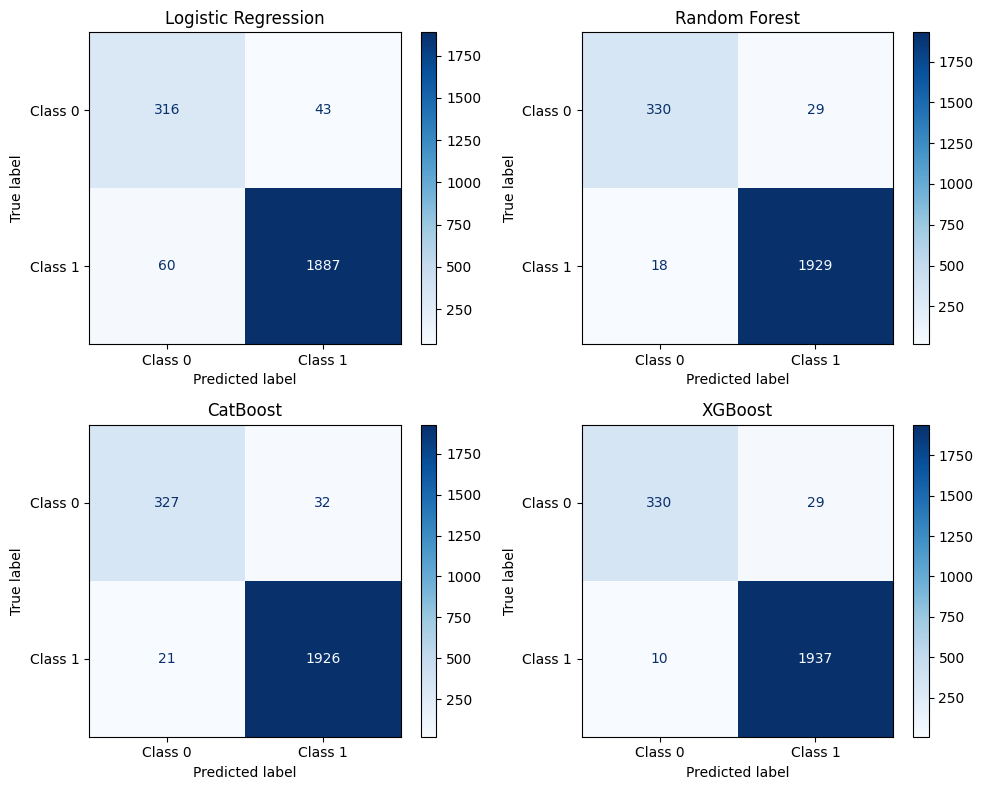

In [61]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# Approximate confusion matrices from your classification reports:
cm_lr =  np.array([[316,  43],
                   [ 60, 1887]])

cm_rf =  np.array([[330,  29],
                   [ 18, 1929]])

cm_cb =  np.array([[327,  32],
                   [ 21, 1926]])

cm_xgb = np.array([[330,  29],
                   [ 10, 1937]])

confusion_dict = {
    'Logistic Regression': cm_lr,
    'Random Forest':       cm_rf,
    'CatBoost':            cm_cb,
    'XGBoost':             cm_xgb
}

fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.ravel()  # Flatten so we can iterate easily

for ax, (model_name, cm) in zip(axes, confusion_dict.items()):
    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm,
        display_labels=["Class 0", "Class 1"]
    )
    disp.plot(ax=ax, cmap='Blues', values_format='d')
    ax.set_title(model_name)

plt.tight_layout()
plt.show()
